## Assigment 3: Transformers for translation 🙊


Have you ever wondered how applications like Google Translate or language translation features in social media platforms work? Behind these impressive technologies are sophisticated machine learning models that can understand and translate text between different languages. One of the most powerful and groundbreaking models used for this purpose is the Transformer model.

In this assignment, you will step into the shoes of an AI researcher and engineer to create your own Transformer model for translating text from English to French. This journey will not only enhance your understanding of machine learning and deep learning but also give you hands-on experience with state-of-the-art techniques in natural language processing.

Let's start by downloading important libraries

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install bert_score
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.9 MB/s eta 0:00:00
  Pre

For this assignment we are using the IWSLT2017 dataset (read more about it [here](https://huggingface.co/datasets/IWSLT/iwslt2017) ). This dataset easily found in Huggingface fits perfectly for our machine translation task.

In [2]:
from datasets import load_dataset

dataset = load_dataset("IWSLT/iwslt2017",'iwslt2017-en-fr')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

iwslt2017.py:   0%|          | 0.00/8.17k [00:00<?, ?B/s]

The repository for IWSLT/iwslt2017 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IWSLT/iwslt2017.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


en-fr.zip:   0%|          | 0.00/27.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/232825 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8597 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/890 [00:00<?, ? examples/s]

Just to have an idea let's have a quick peak at what our dataset looks like.

In [3]:
dataset['train']['translation'][0]

{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.",
 'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}

Since we don't want to take 8 hours training, let's trim our dataset a bit (although this might lead to underperformance, feel free to use the complete dataset if you have the computing power).

SUGESTION: start with a small dataset to debug your code and increase it gradually (the same principle applies for the number of epochs, batch size, test set size...).

In [4]:
# trim_dataset= dataset['train']['translation'][:100000]

In [5]:
# Trimming the dataset to a smaller size for debugging and faster prototyping
trimmed_dataset = dataset['train']['translation'][:20000]

# Print a sample to verify
print(trimmed_dataset[0])

{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}


### Preprocessing


Same as our previous assignments preprocessing is an essential part of any NLP task.

In [6]:
# import string
# def preprocess_data(text):
#   """ Method to clean text from noise and standarize text across the different classes.
#       The preprocessing includes converting to joining all datapoints, lowercase, removing punctuation, and removing stopwords.
#   Arguments
#   ---------
#   text : List of String
#      Text to clean
#   Returns
#   -------
#   text : String
#       Cleaned and joined text
#   """

#   text = text.lower() #make everything lower case
#   text = text.replace('\n',' ') #remove \n characters
#   text = re.sub(r'[^\w\s]', ' ', text) #remove any punctuation or special characters
#   text = ' '.join([word for word in text.split(" ") if word.isalpha()]) #remove all numbers

#   return text


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
def preprocess_data(text):
    """ Method to clean text from noise and standardize text across the different classes.
        The preprocessing includes converting to lowercase, removing punctuation, and removing stopwords.
    Arguments
    ---------
    text : String
        Text to clean
    Returns
    -------
    text : String
        Cleaned text
    """

    # Make everything lower case
    text = text.lower()

    # Remove newline characters
    text = text.replace('\n', ' ')

    # Remove any punctuation or special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove all numbers
    text = ' '.join([word for word in text.split(" ") if word.isalpha()])

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text


For an easier training structure, it is useful to format our training and validation sets. The following function should help with this.

In [9]:
import re
import string
from nltk.corpus import stopwords
def create_dataset(dataset, source_lang, target_lang):
    """
    Method to create a dataset from a list of text.

    Arguments
    ---------
    dataset : List of Dict
        List of dictionary objects with source and target text
    source_lang : String
        Source language key in the dataset
    target_lang : String
        Target language key in the dataset

    Returns
    -------
    new_dataset : List of Tuples
        Cleaned source and target text in format (source, target)
    """
    new_dataset = []
    for example in dataset:
        # Extract source and target text
        source_text = example.get(source_lang, "")
        target_text = example.get(target_lang, "")

        # Preprocess source and target text
        clean_source = preprocess_data(source_text)
        clean_target = preprocess_data(target_text)

        # Append to the dataset
        new_dataset.append((clean_source, clean_target))
    return new_dataset

# Applying the preprocessing and formatting the training, validation, and test sets
training_set = create_dataset(trimmed_dataset, 'en', 'fr')
validation_set = create_dataset(dataset['validation']['translation'], 'en', 'fr')
test_set = create_dataset(dataset['test']['translation'], 'en', 'fr')

### Model Creation


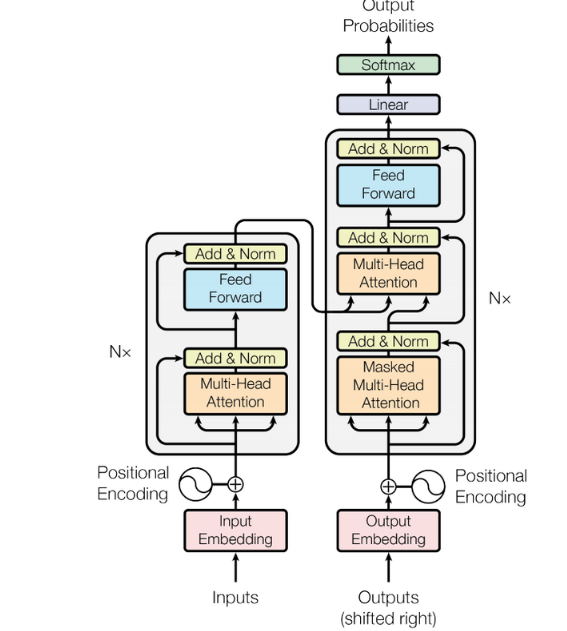

Now that our data is ready, we can get started. Let's start by creating our Sequence to Sequence Transformer model.

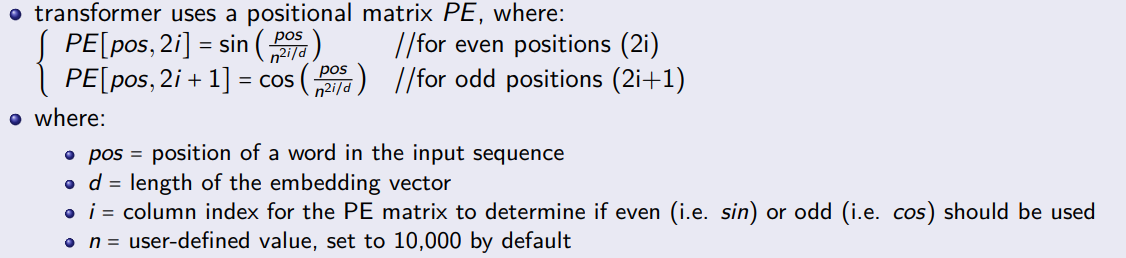

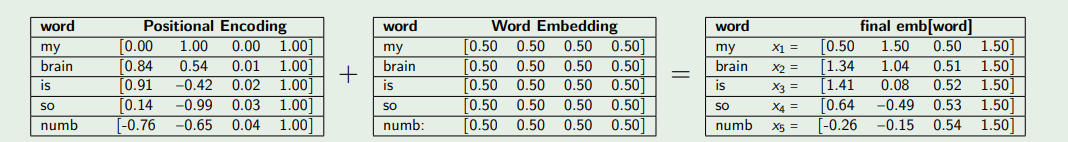

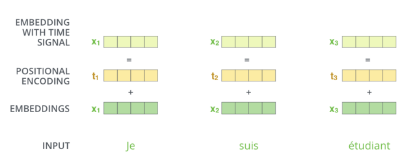

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)  # Embedding layer for source language
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)  # Embedding layer for target language
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Ensure the batch dimension is first
        )
        self.fc = nn.Linear(d_model, tgt_vocab_size)  # Last linear layer

    def positional_encoding(self, d_model, maxlen=5000):
        """Method to create a positional encoding buffer."""
        pos = torch.arange(0, maxlen).unsqueeze(1)
        denominator = 10000 ** (torch.arange(0, d_model, 2) / d_model)

        PE = torch.zeros((maxlen, d_model))
        PE[:, 0::2] = torch.sin(pos / denominator)  # Calculate sin for even positions
        PE[:, 1::2] = torch.cos(pos / denominator)  # Calculate cosine for odd positions

        PE = PE.unsqueeze(0)  # Add batch dimension

        return PE

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """Method to forward a batch of data through the model."""
        # Pass source and target through embedding layer
        src = self.src_embedding(src)
        tgt = self.tgt_embedding(tgt)

        positional_encoding = self.positional_encoding(d_model=src.shape[2]).to(src.device)  # Get positional encoding and move it to device

        # Get src_emb and tgt_emb by adding positional encoder
        src_emb = src + positional_encoding[:, :src.shape[1], :]
        tgt_emb = tgt + positional_encoding[:, :tgt.shape[1], :]

        # Pass src, tgt, and all masks through transformer
        output = self.transformer(
            src_emb, tgt_emb,
            src_mask, tgt_mask,
            None,  # Memory mask not used here
            src_key_padding_mask, tgt_key_padding_mask,
            src_key_padding_mask
        )

        # Pass output through linear layer
        output = self.fc(output)
        return output

    def encode(self, src, src_mask):
        """Method to encode a batch of data through the transformer model."""
        src = self.src_embedding(src)  # Pass src through embedding layer
        positional_encoding = self.positional_encoding(d_model=src.shape[2]).to(src.device)  # Create positional encoding
        src_emb = src + positional_encoding[:, :src.shape[1], :]  # Get src_emb
        return self.transformer.encoder(src_emb, src_mask)  # Pass src_emb through transformer encoder

    def decode(self, tgt, memory, tgt_mask):
        """Method to decode a batch of data through the transformer model."""
        tgt = self.tgt_embedding(tgt)  # Pass tgt through embedding layer
        positional_encoding = self.positional_encoding(d_model=tgt.shape[2]).to(tgt.device)  # Create positional encoding
        tgt_emb = tgt + positional_encoding[:, :tgt.shape[1], :]  # Get tgt_emb
        return self.transformer.decoder(tgt_emb, memory, tgt_mask)  # Pass tgt_emb through transformer decoder


Now that our model is ready, we still need some methods that will come in handy during training.

seq = [7, 4, 0, 0]

mask = [0, 0, 1, 1]

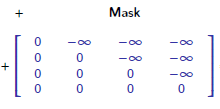

In [11]:
import torch

def create_padding_mask(seq):
    """
    Method to create a padding mask based on given sequence.
    Arguments
    ---------
    seq : Tensor
       Sequence to create padding mask for
    Returns
    -------
    mask : Tensor
        Padding mask
    """
    # Create a mask where padded tokens (value 0) are marked as 1
    mask = (seq == 0).float()
    return mask  # Return a 2-D tensor with shape (batch_size, sequence_length)

def create_triu_mask(sz):
    """
    Method to create a triangular mask based on given sequence.
    This is used for the tgt mask in the Transformer model to avoid looking ahead.
    Arguments
    ---------
    sz : int
       Size of the mask
    Returns
    -------
    mask : Tensor
        Triangular mask
    """
    # Create a lower triangular matrix with 1's in the lower triangle and 0's elsewhere
    mask = torch.triu(torch.ones(sz, sz), diagonal=1).transpose(0, 1).float()
    # Replace 0 with 0.0 and 1 with -inf
    mask = mask.masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, float(0.0))
    return mask

def tokenize_batch(source, targets, tokenizer):
    """
    Method to tokenize a batch of data given a tokenizer.
    Arguments
    ---------
    source : List of String
       Source text
    targets : List of String
       Target text
    tokenizer : Tokenizer
       Tokenizer to use for tokenization
    Returns
    -------
    tokenized_source : Tensor
        Tokenized source text
    tokenized_targets : Tensor
        Tokenized target text
    """
    tokenized_source = tokenizer(source, padding='max_length', max_length=120, truncation=True, return_tensors='pt')
    tokenized_targets = tokenizer(targets, padding='max_length', max_length=120, truncation=True, return_tensors='pt')


    return tokenized_source['input_ids'], tokenized_targets['input_ids']


### Training


512 - d_model

8 - nhead

3 - num_encoder_layers

3 - num_decoder_layers

256 - dim_feedforward

0.1 - dropout

In [12]:
from transformers import AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer=AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-uncased')
# PAD_IDX = tokenizer.pad_token_id #for padding
# BOS_IDX = tokenizer.bos_token_id #for beggining of sentence
# EOS_IDX = tokenizer.eos_token_id #for end of sentence

PAD_IDX = tokenizer.pad_token_id #for padding
BOS_IDX = tokenizer.cls_token_id if tokenizer.cls_token_id else tokenizer.pad_token_id #for beggining of sentence
EOS_IDX = tokenizer.sep_token_id if tokenizer.sep_token_id else tokenizer.pad_token_id #for end of sentence

model = TransformerModel(tokenizer.vocab_size, tokenizer.vocab_size,512, 8, 3, 3, 256,0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
loss_function = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)


# Update DataLoader batch size
train_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)


# train_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [13]:
print(f"BOS_IDX: {BOS_IDX}, EOS_IDX: {EOS_IDX}")


BOS_IDX: 101, EOS_IDX: 102


Source Mask (src_mask): Created as a zero matrix of shape Sequence x Sequence. This mask allows the encoder to attend to the entire input sequence.

Target Mask (tgt_mask): Created using the create_triu_mask function to ensure that each token in the decoder can only attend to the tokens before it, preventing "looking ahead."

Padding Masks (src_padding_mask and tgt_padding_mask): Created for the source and target to ignore the padding tokens during the training process.

In [14]:
from torch.utils.data import DataLoader
from torch.amp import autocast
from tqdm import tqdm
def train_epoch(model, train_loader, tokenizer, scaler, accumulation_steps=4):
    model.train()
    losses = 0
    optimizer.zero_grad()  # Initialize gradients

    for batch_idx, (src, tgt) in enumerate(tqdm(train_loader)):
        src, tgt = tokenize_batch(src, tgt, tokenizer)
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_out = tgt[:, 1:]

        src_mask = torch.zeros((src.size(1), src.size(1)), device=device)
        tgt_mask = create_triu_mask(tgt_input.size(1)).to(device)
        src_padding_mask = create_padding_mask(src).to(device)
        tgt_padding_mask = create_padding_mask(tgt_input).to(device)

        # Mixed precision forward pass
        with autocast(device_type='cuda'):  # Specify the device type
            logits = model(
                src, tgt_input,
                src_mask=src_mask, tgt_mask=tgt_mask,
                src_key_padding_mask=src_padding_mask, tgt_key_padding_mask=tgt_padding_mask
            )
            loss = loss_function(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            loss = loss / accumulation_steps

        # Backward pass with scaled gradients
        scaler.scale(loss).backward()

        # Perform optimizer step after accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        losses += loss.item()

    return losses / len(list(train_loader))





def evaluate(model, val_dataloader):
    model.eval()
    losses = 0
    with torch.no_grad():
        for src, tgt in tqdm(val_dataloader):
            # Tokenize and move to device
            src, tgt = tokenize_batch(src, tgt, tokenizer)
            src = src.to(device)
            tgt = tgt.to(device)

            # Shift target for teacher forcing
            tgt_input = tgt[:, :-1]

            # Create masks
            src_mask = torch.zeros((src.size(1), src.size(1)), device=device)  # Sequence x Sequence mask filled with zeros
            tgt_mask = create_triu_mask(tgt_input.size(1)).to(device)  # Create triangular mask for target

            src_padding_mask = create_padding_mask(src).to(device)  # Create padding mask for source
            tgt_padding_mask = create_padding_mask(tgt_input).to(device)  # Create padding mask for target

            # Forward pass through the model
            logits = model(
                src, tgt_input,
                src_mask=src_mask, tgt_mask=tgt_mask,
                src_key_padding_mask=src_padding_mask, tgt_key_padding_mask=tgt_padding_mask
            )

            # Compute loss
            tgt_out = tgt[:, 1:]  # Shifted target output
            loss = loss_function(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()  # Accumulate loss

    return losses / len(list(val_dataloader))


Now we can start training! Keep in mind this code is very demanding computationally, it has been set to 10 epochs (which can take up to 6-8 hours) but feel free to change this value depending on your resources, in this case the more epochs you can execute the better 😀

In [15]:
from torch.amp import GradScaler, autocast

def train(model, epochs, train_loader, validation_loader):
    scaler = GradScaler()  # Initialize the gradient scaler
    for epoch in range(1, epochs + 1):
        # Pass the scaler to train_epoch
        train_loss = train_epoch(model, train_loader, tokenizer, scaler)
        val_loss = evaluate(model, validation_loader)
        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

train(model, 2, train_loader, validation_loader)


100%|██████████| 56/56 [00:05<00:00,  9.80it/s]


Epoch: 1, Train loss: 1.633, Val loss: 4.856


100%|██████████| 56/56 [00:05<00:00,  9.77it/s]

Epoch: 2, Train loss: 0.996, Val loss: 3.530


In [16]:
import torch

# Assuming `tokenizer` has already been instantiated with your model's tokenizer
# For example: tokenizer = AutoTokenizer.from_pretrained('facebook/xlm-roberta-base')

# Define a sample sentence to be translated
sample_sentence = "How are you today?"

# Tokenize the sample sentence
tokenized_input = tokenizer([sample_sentence], padding='max_length', max_length=50, return_tensors='pt')

# Convert the tokenized input to a tensor
input_tensor = tokenized_input['input_ids']

# Check the shape and contents of the input tensor
print("Tokenized Input:", tokenized_input)
print("Input Tensor Shape:", input_tensor.shape)
print("Input Tensor:", input_tensor)

# Move the input tensor to device if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

# Check positional encoding if using
model.eval()
with torch.no_grad():
    positional_encoding = model.positional_encoding(d_model=input_tensor.size(-1)).to(input_tensor.device)
    print("Positional Encoding Shape:", positional_encoding.shape)

# Create source mask
src_mask = torch.zeros((input_tensor.size(1), input_tensor.size(1)), device=device)
print("Source Mask Shape:", src_mask.shape)

# Pass through the model for a test run (encoding only)
with torch.no_grad():
    encoded_output = model.encode(input_tensor, src_mask)
    print("Encoded Output Shape:", encoded_output.shape)


Tokenized Input: {'input_ids': tensor([[  101, 12548, 10320, 10855, 13980,   136,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}
Input Tensor Shape: torch.Size([1, 50])
Input Tensor: tensor([[  101, 12548, 10320, 10855, 13980,   136,   102,     0,     0,     0,
             0,     0,     0,     0,     0

The positional encoding tensor has a shape [1, 5000, 50].

[1]: Batch size.
[5000]: Maximum length for positional encodings (the value you provided in the
function).

[50]: Embedding dimension (which matches your input sequence length).

The source mask is a square matrix of size [50, 50], which corresponds to the sequence length of the input tensor.

The encoded output has a shape [1, 50, 512]:

[1]: Batch size.

[50]: Sequence length.

[512]: Embedding dimension.

### Testing


In this assignment, we will use three different evaluation metrics to see our model's test performance: [Bert Score](https://huggingface.co/spaces/evaluate-metric/bertscore), [Meteor](https://huggingface.co/spaces/evaluate-metric/meteor) and [Rouge](https://huggingface.co/spaces/evaluate-metric/rouge). Please access their hugging face documentation to know how to implement them.

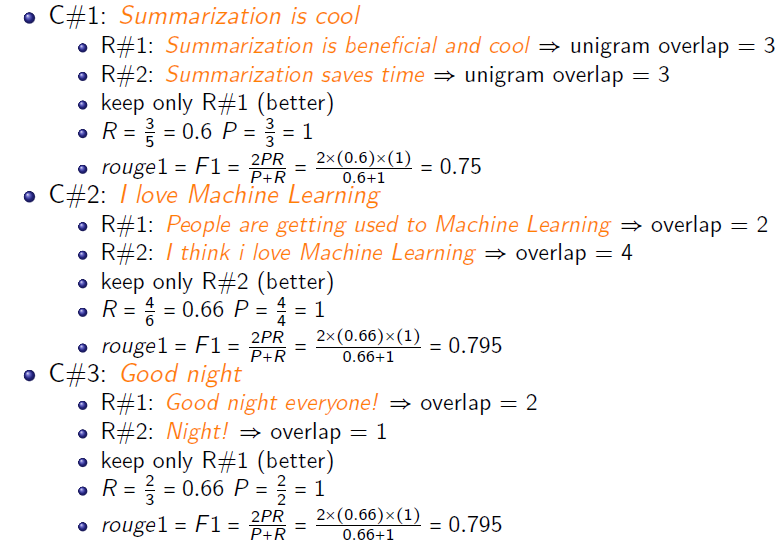

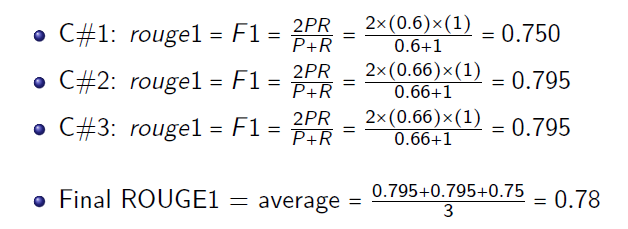

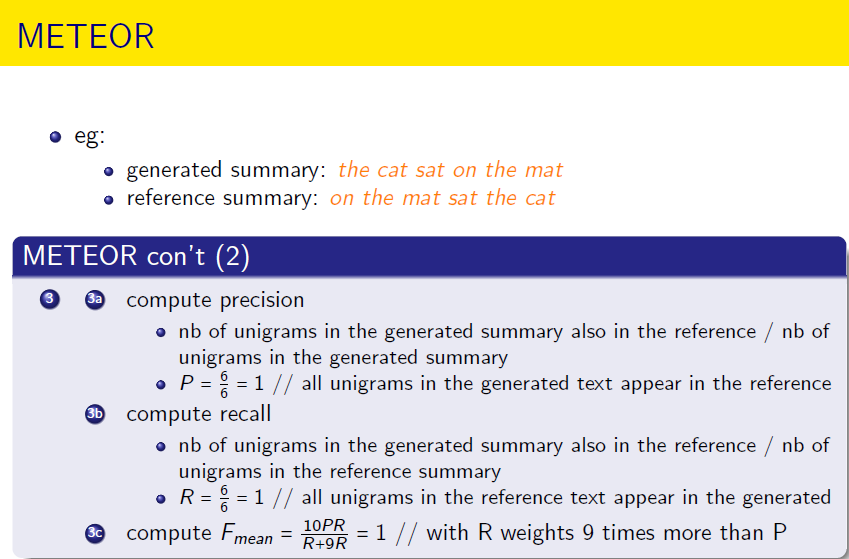

In [17]:
from evaluate import load
bertscore = load("bertscore")
rouge = load('rouge')
meteor = load('meteor')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Implement greedy decode as seen in class in the NLG slides.

In [56]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, repetition_penalty=1.5, top_k=10, max_repetitions=5):
    """
    Greedy decoding with repetition penalty and top-k sampling without temperature.

    Args:
        model: The trained model.
        src: Input sequence tensor.
        src_mask: Mask for the input sequence.
        max_len: Maximum output length.
        start_symbol: The ID of the starting token.
        repetition_penalty: Penalize repeated tokens in logits (default: 1.5).
        top_k: The number of top tokens to consider in the sampling (default: 10).
        max_repetitions: Number of repetitive tokens to trigger early stop.

    Returns:
        Tensor of generated token IDs.
    """
    # Move source to device
    src = src.to(device)
    src_mask = src_mask.to(device)

    # Pass through encoder
    memory = model.encode(src, src_mask)

    # Start decoding with the <BOS> token
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    repetition_counter = defaultdict(int)

    for i in range(max_len - 1):
        # Generate target mask
        tgt_mask = create_triu_mask(ys.size(1)).to(device)

        # Pass through the decoder to get logits
        out = model.decode(ys, memory, tgt_mask)
        logits = model.fc(out[:, -1])

        # Apply repetition penalty
        for token_id, count in repetition_counter.items():
            if count > 0:
                logits[0, token_id] /= (repetition_penalty ** count)

        # Apply top-k sampling
        topk_prob, topk_indices = torch.topk(logits, top_k, dim=-1)
        next_word_index = torch.multinomial(torch.nn.functional.softmax(topk_prob, dim=-1), 1).item()
        next_word = topk_indices[0, next_word_index].item()

        # Stop if end-of-sequence token is generated
        if next_word == EOS_IDX:
            break

        # Update repetition counter
        repetition_counter[next_word] += 1

        # Append the generated token to the target sequence (ys)
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)

        # Early stopping for excessive repetition
        if repetition_counter[next_word] >= max_repetitions:
            break

    return ys





In [57]:
def translate(model: torch.nn.Module, src_sentence: str, tokenizer):
    model.eval()
    src, _ = tokenize_batch(src_sentence, "", tokenizer)
    src = src.to(device)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.float).to(device)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len= int(num_tokens * 1.2 ), start_symbol=BOS_IDX).flatten()
    return tokenizer.decode(tgt_tokens, skip_special_tokens=True)

In [ ]:
# tokens = [tokenizer.cls_token_id, tokenizer.convert_tokens_to_ids('hello'), tokenizer.convert_tokens_to_ids('world'), tokenizer.sep_token_id]
# decoded = tokenizer.decode(tokens, skip_special_tokens=True)
# print(decoded)  # Should output: "hello world"


In [58]:
print(translate(model, "Hello how are you today", tokenizer))


un un avoir ai ai j j ava nous tout dire si si meme une une chose chose tous elles elles sont sont en en voir son aussi aussi cela cela mon dit maintenant avait au au est ceci etre etre peut peut comme vers ici bien bien il il alors pas pas pas assez vous vous va beaucoup beaucoup juste juste etait c donc donc ca ca besoin des des desre vot quelque quelque sorte ce ce ce qui qui ceux dont pourtt avec avec avecientititrr comment pense sur encores somme non non la science notre quelqu fait fait et etzz ave plus plus tard


In [59]:
print(f"BOS_IDX: {BOS_IDX}, EOS_IDX: {EOS_IDX}")

BOS_IDX: 101, EOS_IDX: 102


In [60]:
print(translate(model, "Hi", tokenizer))

un un comme comme aussi peut peut tous tous ces tres tres tres va beaucoup beaucoup sur sur cela cela bien tout tout tout pour pour faire faire con con je je suis avoir avoir j j dit dit meme ce auxons comment si si chose quelque juste pas pas n pense ont ontx etre etre etre


In [49]:
pip install bert_score nltk


In [63]:
import numpy as np
from evaluate import load

# Load evaluation metrics
bertscore = load("bertscore")
meteor = load('meteor')

# You can also trim test_loader
def test(test_loader, model, tokenizer, device, max_length=200):
    """Method to test our model using bertscore and meteor metrics.
    Arguments
    ---------
    test_loader: Dataloader
        Dataloader that holds test set
    model: nn.Module
        Trained Machine Translation model
    tokenizer: Tokenizer
        Tokenizer used for translating and decoding sequences
    device: torch.device
        Device to run the model on (e.g., 'cuda' or 'cpu')
    max_length: int
        Maximum length of output sequence

    Returns
    -------
    precision, recall, f1, meteor_metric : float
        Evaluation metrics for the test set
    """
    precision = 0
    recall = 0
    f1 = 0
    meteor_metric = 0

    for src, target in test_loader:
        # Tokenize the source sentences and convert to tensor
        src_tensor, _ = tokenize_batch([src], [""], tokenizer)
        src_tensor = src_tensor.to(device)

        # Translate the source sentences
        translated_output = translate(model, tokenizer.decode(src_tensor[0]), tokenizer)

        # Decode the target sentence
        target_sentence = target[0]

        # Calculate BERTScore
        bert_results = bertscore.compute(predictions=[translated_output], references=[target_sentence], lang='fr')

        # Calculate METEOR
        meteor_results = meteor.compute(predictions=[translated_output], references=[target_sentence])

        # Accumulate the metrics
        precision += bert_results['precision'][0]
        recall += bert_results['recall'][0]
        f1 += bert_results['f1'][0]
        meteor_metric += meteor_results['meteor']

    # Calculate the average for each metric
    num_samples = len(test_loader)
    return precision / num_samples, recall / num_samples, f1 / num_samples, meteor_metric / num_samples

# Test the model
precision, recall, f1, meteor_metric = test(test_set, model, tokenizer, device)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, METEOR: {meteor_metric:.3f}")









[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [64]:
for i in range(3):
    src_sentence, _ = test_set[i]  #
    print(f"Source: {src_sentence}")
    translated = translate(model, src_sentence, tokenizer)
    print(f"Translation: {translated}")
    print('-' * 50)


Source: several years ago ted peter skillman introduced design challenge called marshmallow challenge
Translation: alors ce ce qui qui qui dit dit et notre mon mon chaque il il il bien tout tout tout ou ou crois tous une autre juste justeons aux aux etats unis avec avectt dansre vot nos nos nos commence ai ai j maintenant maintenant etre etre chose quelque peut peut vous vous voye que que parce elles elles sont sont des des deux deux ans comme comme entre entre entre app c c etait etait moi moi pour pour verssrion n je je suis suis con nous nous avoir avoirzz ave jamais est est dieu ces ces tres tres aussi aussi faire faire faire voir voirntnt pas pas mais mais ca ca meme pense fait en en au au delaux encore sorte ete ete ceci comment si si de de
--------------------------------------------------
Source: idea pretty simple teams four build tallest free standing structure sticks spaghetti one yard tape one yard string marshmallow
Translation: par par par etait etait le le voir tout tout

## Let's experiment!

1. Play with a hyperparameter of your choice to measure its effect on the translation.

2. Compare the results of your model with the performance of using the T5 pretrained model. This [tutorial](https://huggingface.co/docs/transformers/en/tasks/translation) on using T5 for machine translation might come in handy.

Experiment

- Learning Rate(e.g., 1e-5, 1e-4, 1e-3)
- Batch Size (16, 32, 64)
- max_length  (e.g., 50, 100, 200 tokens)
- Dropout Rate (e.g., 0.1, 0.3, 0.5)

# **T5**

In [65]:
# from transformers import T5ForConditionalGeneration, T5Tokenizer
# import torch

# # Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the T5 model and tokenizer
# model_name = "t5-small"  # or "t5-base" for a larger model
# t5_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
# t5_tokenizer = T5Tokenizer.from_pretrained(model_name)

# print("T5 model and tokenizer loaded successfully!")



config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5 model and tokenizer loaded successfully!


In [66]:
# def preprocess_t5_input(src_sentences, source_lang="English", target_lang="French"):
#     """
#     Prepare input sentences for T5 translation.
#     Args:
#         src_sentences: List of sentences in the source language.
#         source_lang: Name of the source language.
#         target_lang: Name of the target language.

#     Returns:
#         List of preprocessed sentences.
#     """
#     return [f"translate {source_lang} to {target_lang}: {sentence}" for sentence in src_sentences]


In [67]:
# def translate_with_t5(t5_model, t5_tokenizer, sentences, device, max_length=200):
#     """
#     Translate a list of sentences using a pretrained T5 model.
#     Args:
#         t5_model: Pretrained T5 model.
#         t5_tokenizer: Tokenizer for the T5 model.
#         sentences: List of input sentences.
#         device: Device to perform computation (CPU/GPU).
#         max_length: Maximum length for the output sequence.

#     Returns:
#         List of translated sentences.
#     """
#     # Preprocess sentences for T5
#     inputs = t5_tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

#     # Generate translations
#     outputs = t5_model.generate(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, max_length=max_length)

#     # Decode the outputs
#     translations = t5_tokenizer.batch_decode(outputs, skip_special_tokens=True)
#     return translations


In [68]:
# # Assuming `test_src_sentences` is a list of sentences
# test_src_sentences = [
#     "This is a test sentence.",
#     "How are you today?",
#     "Machine learning is amazing!"
# ]

# # Perform translation on the entire batch using translate_with_t5
# custom_model_translations = translate_with_t5(
#     t5_model,           # The pretrained T5 model
#     t5_tokenizer,       # The tokenizer for T5
#     test_src_sentences, # List of source sentences
#     device=device,      # Device (CPU or GPU)
#     max_length=200      # Maximum output sequence length
# )

# # Display translations
# print("Custom model translations:")
# for src, translation in zip(test_src_sentences, custom_model_translations):
#     print(f"Source: {src}\nTranslation: {translation}\n")



Custom model translations:
Source: This is a test sentence.
Translation: Dies is a test sentence.

Source: How are you today?
Translation: Wie seid Sie heute?

Source: Machine learning is amazing!
Translation: Die Technik Maschine learning ist unglaublich!



evaluate

In [69]:
!pip install bert_score


In [70]:
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')  # برای پشتیبانی از زبان‌های دیگر در METEOR


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [71]:
# from bert_score import score as bert_score  # For BERTScore
# from nltk.translate.meteor_score import single_meteor_score

# def evaluate_translation_model(model, tokenizer, test_sentences, reference_sentences, device, is_t5=False, max_length=200):
#     generated_translations = []
#     meteor_metric = 0

#     # Translate sentences
#     for src_sentence in test_sentences:
#         if is_t5:
#             inputs = tokenizer(src_sentence, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
#             outputs = model.generate(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, max_length=max_length)
#             translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
#         else:
#             translation = translate(model, src_sentence, tokenizer)
#         generated_translations.append(translation)

#     # Compute BERTScore
#     P, R, F1 = bert_score(generated_translations, reference_sentences, lang="en")
#     precision = P.mean().item()
#     recall = R.mean().item()
#     f1 = F1.mean().item()

#     # Compute METEOR score
#     for ref, hyp in zip(reference_sentences, generated_translations):
#         meteor_metric += single_meteor_score(ref.split(), hyp.split())

#     return precision, recall, f1, meteor_metric / len(reference_sentences)


In [72]:
# test_src_sentences = [
#     "Translate this sentence from English to French.",
#     "The quick brown fox jumps over the lazy dog."
# ]
# test_ref_sentences = [
#     "Traduisez cette phrase de l'anglais au français.",
#     "Le renard brun rapide saute par-dessus le chien paresseux."
# ]

# t5_results = evaluate_translation_model(
#     model=t5_model,
#     tokenizer=t5_tokenizer,
#     test_sentences=test_src_sentences,
#     reference_sentences=test_ref_sentences,
#     device=device,
#     is_t5=True
# )
# print(f"T5 Model - Precision: {t5_results[0]:.4f}, Recall: {t5_results[1]:.4f}, F1: {t5_results[2]:.4f}, METEOR: {t5_results[3]:.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 Model - Precision: 0.7384, Recall: 0.7646, F1: 0.7494, METEOR: 0.0000


In [73]:
# generated_translations = [
#     "Translate this sentence from English to French.",
#     "The quick brown fox jumps over the lazy dog."
# ]
# reference_sentences = [
#     "Traduisez cette phrase de l'anglais au français.",
#     "Le renard brun rapide saute par-dessus le chien paresseux."
# ]


In [74]:
# # Evaluate using BERTScore
# P, R, F1 = bert_score(generated_translations, reference_sentences, lang="en")
# precision = P.mean().item()
# recall = R.mean().item()
# f1 = F1.mean().item()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
# print(f"T5 Model - Precision: {t5_results[0]:.4f}, Recall: {t5_results[1]:.4f}, F1: {t5_results[2]:.4f}, METEOR: {t5_results[3]:.4f}")


T5 Model - Precision: 0.7384, Recall: 0.7646, F1: 0.7494, METEOR: 0.0000


New Ver

In [78]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [82]:
# Download nltk data
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [79]:
def preprocess_t5_input_for_training(dataset, source_lang="English", target_lang="French"):
    """
    Prepare input sentences for T5 training.
    Args:
        dataset: List of tuples (source_sentence, target_sentence)
        source_lang: Name of the source language.
        target_lang: Name of the target language.

    Returns:
        List of preprocessed sentences and corresponding targets.
    """
    inputs = [f"translate {source_lang} to {target_lang}: {src}" for src, tgt in dataset]
    targets = [tgt for src, tgt in dataset]
    return inputs, targets

# Preprocessing training, validation, and test data
train_inputs, train_targets = preprocess_t5_input_for_training(training_set)
val_inputs, val_targets = preprocess_t5_input_for_training(validation_set)
test_inputs, test_targets = preprocess_t5_input_for_training(test_set)


In [83]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the T5 model and tokenizer
model_name = "t5-small"  # or "t5-base" for a larger model
t5_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)

print("T5 model and tokenizer loaded successfully!")

T5 model and tokenizer loaded successfully!


In [84]:
# Function to translate sentences using T5
def translate_with_t5(t5_model, t5_tokenizer, sentences, device, max_length=200):
    """
    Translate a list of sentences using a pretrained T5 model.
    Args:
        t5_model: Pretrained T5 model.
        t5_tokenizer: Tokenizer for the T5 model.
        sentences: List of input sentences.
        device: Device to perform computation (CPU/GPU).
        max_length: Maximum length for the output sequence.

    Returns:
        List of translated sentences.
    """
    # Preprocess sentences for T5
    inputs = t5_tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate translations
    outputs = t5_model.generate(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, max_length=max_length)

    # Decode the outputs
    translations = t5_tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return translations


In [86]:
# Function to evaluate the translation model using BERTScore and METEOR
def evaluate_translation_model(model, tokenizer, test_sentences, reference_sentences, device, is_t5=False, max_length=200):
    generated_translations = []
    meteor_metric = 0

    # Translate sentences
    for src_sentence in test_sentences:
        if is_t5:
            inputs = tokenizer(src_sentence, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
            outputs = model.generate(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, max_length=max_length)
            translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            translation = translate(model, src_sentence, tokenizer)
        generated_translations.append(translation)

    # Compute BERTScore
    P, R, F1 = bert_score(generated_translations, reference_sentences, lang="en")
    precision = P.mean().item()
    recall = R.mean().item()
    f1 = F1.mean().item()

    # Compute METEOR score
    for ref, hyp in zip(reference_sentences, generated_translations):
        meteor_metric += single_meteor_score(ref.split(), hyp.split())

    return generated_translations, precision, recall, f1, meteor_metric / len(reference_sentences)

# Perform translation and evaluate the model
test_src_sentences = [src for src, _ in test_set[:10]]
test_ref_sentences = [tgt for _, tgt in test_set[:10]]

# Get the translations and evaluation metrics
generated_translations, precision, recall, f1, meteor_metric = evaluate_translation_model(
    model=t5_model,
    tokenizer=t5_tokenizer,
    test_sentences=test_src_sentences,
    reference_sentences=test_ref_sentences,
    device=device,
    is_t5=True
)

# Display sample translations
print("Sample Translations:")
for i in range(5):  # Display first 5 translations
    print(f"Source: {test_src_sentences[i]}")
    print(f"Generated Translation: {generated_translations[i]}")
    print(f"Reference Translation: {test_ref_sentences[i]}\n")

# Display evaluation metrics
print(f"T5 Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, METEOR: {meteor_metric:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sample Translations:
Source: several years ago ted peter skillman introduced design challenge called marshmallow challenge
Generated Translation: ted peter skillman introduced design challenge called marshmallow challenge
Reference Translation: il plusieurs années ici à ted peter skillman présenté une épreuve de conception appelée l épreuve du marshmallow

Source: idea pretty simple teams four build tallest free standing structure sticks spaghetti one yard tape one yard string marshmallow
Generated Translation: teams four build tallest free standing structure sticks spaghetti one yard tape one yard string marshmallow
Reference Translation: et l idée est plutôt simple des équipes de quatre personnes doivent bâtir la plus haute structure tenant debout avec spaghettis un mètre de ruban collant un mètre de ficelle et un marshmallow

Source: marshmallow top
Generated Translation: marshmallow top
Reference Translation: le marshmallow doit être placé au sommet

Source: though seems really sim

In [87]:
from bert_score import score as bert_score  # For BERTScore
from evaluate import load as load_metric  # For loading ROUGE
from nltk.translate.meteor_score import single_meteor_score

# Load ROUGE metric
rouge = load_metric('rouge')

# Function to evaluate the translation model using BERTScore, ROUGE, and METEOR
def evaluate_translation_model(model, tokenizer, test_sentences, reference_sentences, device, is_t5=False, max_length=200):
    generated_translations = []
    meteor_metric = 0

    # Translate sentences
    for src_sentence in test_sentences:
        if is_t5:
            inputs = tokenizer(src_sentence, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
            outputs = model.generate(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, max_length=max_length)
            translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            translation = translate(model, src_sentence, tokenizer)
        generated_translations.append(translation)

    # Compute BERTScore
    P, R, F1 = bert_score(generated_translations, reference_sentences, lang="en")
    precision = P.mean().item()
    recall = R.mean().item()
    f1 = F1.mean().item()

    # Compute ROUGE score
    rouge_scores = rouge.compute(predictions=generated_translations, references=reference_sentences)

    # Compute METEOR score
    for ref, hyp in zip(reference_sentences, generated_translations):
        meteor_metric += single_meteor_score(ref.split(), hyp.split())

    return generated_translations, precision, recall, f1, meteor_metric / len(reference_sentences), rouge_scores

# Perform translation and evaluate the model
test_src_sentences = [src for src, _ in test_set[:10]]
test_ref_sentences = [tgt for _, tgt in test_set[:10]]

# Get the translations and evaluation metrics
generated_translations, precision, recall, f1, meteor_metric, rouge_scores = evaluate_translation_model(
    model=t5_model,
    tokenizer=t5_tokenizer,
    test_sentences=test_src_sentences,
    reference_sentences=test_ref_sentences,
    device=device,
    is_t5=True
)

# Display sample translations
print("Sample Translations:")
for i in range(5):  # Display first 5 translations
    print(f"Source: {test_src_sentences[i]}")
    print(f"Generated Translation: {generated_translations[i]}")
    print(f"Reference Translation: {test_ref_sentences[i]}\n")

# Display evaluation metrics
print(f"T5 Model - Precision (BERTScore): {precision:.4f}, Recall (BERTScore): {recall:.4f}, F1 (BERTScore): {f1:.4f}, METEOR: {meteor_metric:.4f}")
print(f"ROUGE Scores: {rouge_scores}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sample Translations:
Source: several years ago ted peter skillman introduced design challenge called marshmallow challenge
Generated Translation: ted peter skillman introduced design challenge called marshmallow challenge
Reference Translation: il plusieurs années ici à ted peter skillman présenté une épreuve de conception appelée l épreuve du marshmallow

Source: idea pretty simple teams four build tallest free standing structure sticks spaghetti one yard tape one yard string marshmallow
Generated Translation: teams four build tallest free standing structure sticks spaghetti one yard tape one yard string marshmallow
Reference Translation: et l idée est plutôt simple des équipes de quatre personnes doivent bâtir la plus haute structure tenant debout avec spaghettis un mètre de ruban collant un mètre de ficelle et un marshmallow

Source: marshmallow top
Generated Translation: marshmallow top
Reference Translation: le marshmallow doit être placé au sommet

Source: though seems really sim

In [90]:
# Calculate the average F1 score from the available ROUGE scores
avg_f1_score = (rouge_scores['rouge1'] +
                rouge_scores['rouge2'] +
                rouge_scores['rougeL']) / 3

print(f"Average ROUGE F1 Score: {avg_f1_score:.4f}")



Average ROUGE F1 Score: 0.0631


In [89]:
print(rouge_scores)


{'rouge1': 0.08738200975269941, 'rouge2': 0.014814814814814814, 'rougeL': 0.0871569139672588, 'rougeLsum': 0.08575539881574365}


In [91]:
avg_f1_score = (rouge_scores['rouge1'] +
                rouge_scores['rouge2'] +
                rouge_scores['rougeL'] +
                rouge_scores['rougeLsum']) / 4

print(f"Average ROUGE F1 Score (including ROUGE-Lsum): {avg_f1_score:.4f}")


Average ROUGE F1 Score (including ROUGE-Lsum): 0.0688
